# Machine Learning Engineer Nanodegree
## Capstone Project
Tim Black 
September 5, 2018

## I. Definition

### Project Overview
In order for cities to plan transportation systems, they need to have robust data on the number of people using different modes of transport. This is especially important when the urban landscape changes, such as an increase in urban density, and cities need to plan for the changes in traffic that will arrive. Typically, cities collect data on the volume of vehicle, bicycle, and pedestrian traffic. Unfortunately, collecting these data is costly and time consuming, and in some cases impossible. Often transportation engineers and planners need to understand the consequences of different design decisions, such as the estimated effect of a traffic signal on safety. Since it is impossible to build out these alternatives and then perform volume counts, engineers and planners need a way to be able to estimate the effect of changes on pedestrian volume.

Although many cities have models to estimate the effect of the built environment on pedestrian volume, they are typically at the scale of traffic analysis zones, a geographic scale much larger compared to the intersection. Intersection-based models exist for the following locations: San Francisco, CA (1,2); Charlotte, NC (3); Alameda County, CA (4); San Diego County, CA (5); Santa Monica, CA (6); and Quebec (7). Most of these intersection-based models use either a linear or log-linear model, and the most common features found to significantly affect pedestrian volumes include population density, employment density, and transit accessibility.

Despite general agreement on the most important features, there are differences among the models on other significant features from the built environment. For example, the City of Santa Monica found the distance from the ocean to be a significant variable in prediction (6); it is highly unlikely that a landlocked city would find the significance in that variable. Even when the models agree on which features of the built environment are significant predictors, they often disagree on the extent to which they influence pedestrian volume. As suggested by Schneider et al., this variation should be addressed by creating models that are sensitive to the context of the local environment (2). Since there currently does not exist a model to predict pedestrian intersection volumes for the City of Los Angeles, my machine learning project aims to fill that gap.


### Problem Statement
For this project, my goal is to answer the following statement: What is the relationship between the built environment and the daily pedestrian volumes at intersections in the City of Los Angeles? The first part of the answer to this question requires testing the null hypthesis of:  

$H_o$: There is no relationship between daily pedestrian volumes and the built environment  
versus the alternative hypothesis of:  
$H_a$: There is some relationship between daily pedestrian volumes and the built environment.  

If I can reject the null hypothesis, my goal is to then understand _how_ the built environment affects daily pedestrian volume.

### Metrics
My proposed metric for evaluating my linear model is the r-squared score, the proportion of the variance in the dependent variable that is predictable given the features.  
$${R}^2(y, \hat{y} ) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y})^{2}}{ \sum_{i=1}^{n} (y_i - \bar{y})^{2} }$$

## II. Data Assembly

The Los Angeles Department of Transportation (LADOT) routinely collects volume data related to bicyclists, pedestrians, and motor vehicles for the purposes of transportation planning. Historically, these data have been stored in a PDF format, which makes it easy to digest a single traffic count, but prevents comparison and analysis of multiple counts. These PDF files are publicly available on the Navigate LA portal at http://navigatela.lacity.org/navigatela/. The first step to solving the proposed problem required extracting pedestrian volume from these sheets and storing it in a format that could be used in a model. 

I developed the following python pipeline below to read the pedestrian volume data from the PDF sheets and format them so they can be used in building the model. The daily volume (what I will be constructing a model to predict), is represented by the ‘volume’ attribute in the table.  Each row is a separate count event (‘count_id’), which occurs at an individual intersection (‘ASSETID’, ‘cl_node_id’).

In [131]:
# here insert small image of PDF to show

In [132]:
import cv2
import numpy as np
from operator import itemgetter, attrgetter
try:
    import Image
except ImportError:
    from PIL import Image
import pytesseract

# Set path to tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'
# Define config parameters.
# '-l eng'  for using the English language
# '--oem 1' for using LSTM OCR Engine
config = ('-l eng --oem 0 --psm 10000 -c tessedit_char_whitelist=0123456789')

def GetContours(img):
    # Prep image
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    # Run contour analysis, sort by contour area (descending)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse = True)
    return(contours)

def CropImage(img, contour):
    (x, y, w, h) = cv2.boundingRect(contour)
    crop_img = img[y:y+h, x:x+w]
    return(crop_img)

def TesseractText(img):
    text = pytesseract.image_to_string(img, config=config)
    counts = list(map(int, text.split()))
    return(counts)

def ExtractCellVal(cells, img):
    vol = []
    # for each cell, crop & extract text
    for cell in cells:
        (x, y, w, h) = cell[1], cell[2], cell[3], cell[4]
        crop_img = img[y:y+h, x:x+w]
        val = TesseractText(crop_img)
        vol.append(val[0])
    return(vol)
    
def SortPedCells(contours):
    # Get the bounding box of each contour
    contour_list = []
    contour_len = len(contours)
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        contour_list.append([contour, x, y, w, h])
    contour_a = np.array(contour_list)
    # Sort by x coordinate, split by number of columns (in this case, 2)
    contour_a = contour_a[contour_a[:,1].argsort()]
    pedvol = contour_a[:6]
    schvol = contour_a[6:]
    # Sort top to bottom (descending) by y coordinate
    pedvol = pedvol[pedvol[:,2].argsort()]
    schvol = schvol[schvol[:,2].argsort()]
    return(pedvol, schvol)
    
def AnalyzePedCrossingTable(img, pedtbl_contour):
    # Crop Image, get new contours
    crop_img = CropImage(img, pedtbl_contour[0])
    pedvol_contours = GetContours(crop_img)
    pedvol_cells = pedvol_contours[2:14]
    pedvol_cells, schvol_cells = SortPedCells(pedvol_cells)
    pedvol = ExtractCellVal(pedvol_cells, crop_img)
    schvol = ExtractCellVal(schvol_cells, crop_img)
    return(dict([("Ped", pedvol), ("Sch", schvol)]))
    
def GetPedData(img):
    ped_tbl_contours = GetContours(img)[5:9]
    ped_tbls = []
    for ped_tbl_contour in ped_tbl_contours:
        (x, y, w, h) = cv2.boundingRect(ped_tbl_contour)
        ped_tbls.append([ped_tbl_contour, x, y, w, h])
    ped_tbls = np.array(ped_tbls)
    ped_tbls = sorted(ped_tbls, key=itemgetter(1))
    ped_tbls = sorted(ped_tbls, key=itemgetter(2))
    
    ped_sch_extract = {}
    ped_sch_extract['SL'] = AnalyzePedCrossingTable(img, ped_tbls[:1][0])
    ped_sch_extract['NL'] = AnalyzePedCrossingTable(img, ped_tbls[1:2][0])
    ped_sch_extract['WL'] = AnalyzePedCrossingTable(img, ped_tbls[2:3][0])
    ped_sch_extract['EL'] = AnalyzePedCrossingTable(img, ped_tbls[3:4][0])
    
    # Format as final df
    ped_sch_data = []
    for leg in ped_sch_extract:
        for pedtype in ped_sch_extract[leg]:

            ped_sch_dict = {}
            ped_sch_dict['xing_leg'] = leg
            ped_sch_dict['type'] = pedtype
            ped_sch_dict['volume'] = sum(ped_sch_extract[leg][pedtype])
            ped_sch_data.append(ped_sch_dict)
    
    return(ped_sch_data)

After extracting pedestrian volume data from these sheets, I assembled data from the built environment that I thought could possibly be significant in predicting pedestrian volume at intersections in Los Angeles. These data are public, but were assembled for a previous project at LADOT.  I looked to the literature review to inform the types of data to collect for evaluating. My built environment data (explanatory variables) include:
* Population within 0.25 mi.  (‘SUM_POPTTL’)
* Employment within 0.25 mi. (‘EMPTOT’)
* Count of Schools within 0.25 mi. (‘SCH_CT’)
* Presence of a traffic signal (‘SIG’, 1 = yes, 0 = no)
* Count of transit stops within 100 ft. (‘TRANSITSTOP’)
* Transit Ridership (‘RIDERSHIP’)

I also dropped unneeded columns for the analysis. The final data set, which included both the extracted volumes and the built environment data, looked like the following:

In [133]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import assembled data
raw_data = pd.read_csv('data/FeatureData/featurescombined.csv')

# Drop Unnecessary columns, export final table
raw_data = raw_data.drop(['Unnamed: 0', 'count_id','cl_node_id', 'traffic_id', 'type', 'location',
                          'OBJECTID', 'ASSETID', 'CL_NODE_ID', 'FROM_ST', 'TO_ST', 'file'
                         ], axis=1)
raw_data.drop(['LAT','LON'], axis=1).head(n=1)

,volume,SIG,TRANSITSTOP,RIDERSHIP,SCH_CT,EMPTOT,SUM_POPTTL
0,9,1.0,1.0,4.0,0,211.024148,7.026113


#### Data Cleaning
After completing the data assembly process, I inspected outlier values for the pedestrian volume counts, subsetting out those counts that are outside 3 standard deviations from the mean.

In [134]:
# keep only the ones that are outside +3 to -3 standard deviations of the mean volume
outlier_volume = raw_data[np.abs(raw_data.volume-raw_data.volume.mean()) > (3*raw_data.volume.std())]
print("There are " + str(len(outlier_volume.index)) +
      " volume counts outside +/- 3 st.dev from the mean volume.")

There are 21 volume counts outside +/- 3 st.dev from the mean volume.


I went back to the original PDF files to verify the count information and found 8 counts (of the 21 outliers) where the OCR failed to properly transcribe the values. I removed these 8 inaccurate counts from the dataset. Worried that there was a systematic error in my data processing, I randomly sampled 50 other volume totals. However, among those 50 sampled counts, 100% of them matched up with my totals in the data set. I concluded that the errors were mostly likely limited to those outlier totals.

In [135]:
raw_data = raw_data.drop([205, 453, 487, 736, 1000, 1107, 1109, 1203])

In [ ]:
#here I also need to talk about dropping the rows where volume = 0

## III. Analysis

### Data Exploration
In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_

##### Target Variable (Volume)

In [136]:
raw_data.volume.describe()

count     1658.000000
mean       624.319059
std       1429.175923
min          0.000000
25%         61.000000
50%        197.000000
75%        506.750000
max      20005.000000
Name: volume, dtype: float64

The daily number of people at an intersection in Los Angeles, according to these counts, ranges between 0 and 20,005. Half of the intersections have a daily volume below 200; however, the mean is significantly higher (at 624), suggesting that there are some intersections with significantly higher counts. Using the same  +3 standard deviation threshold as before, I can identify those intersections that appear to be outliers. This calculation resulted in a slightly different set of outliers, since this dataset excludes the erroneous counts.

In [137]:
outlier_volume = raw_data[np.abs(raw_data.volume-raw_data.volume.mean()) > (3*raw_data.volume.std())]

##### Features

In [138]:
raw_data.drop(['volume','LAT','LON'], axis=1).describe()

,SIG,TRANSITSTOP,RIDERSHIP,SCH_CT,EMPTOT,SUM_POPTTL
count,1658.000000,1658.000000,766.000000,1658.000000,1658.000000,1658.000000
mean,0.548251,0.986731,1024.469051,0.753317,2246.172610,2650.709126
std,0.497817,1.354870,5754.514715,0.957802,5262.601084,1878.186519
min,0.000000,0.000000,0.000000,0.000000,14.084445,0.000000
25%,0.000000,0.000000,49.000000,0.000000,320.761690,1270.147830
50%,1.000000,0.000000,154.000000,0.000000,736.141869,2231.823788
75%,1.000000,2.000000,573.307692,1.000000,1862.655654,3528.763198
max,1.000000,7.000000,104376.101400,7.000000,60793.278700,12858.609440


### Exploratory Visualization
In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

##### Target Variable (Volume)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F7771F4A8>]], dtype=object)

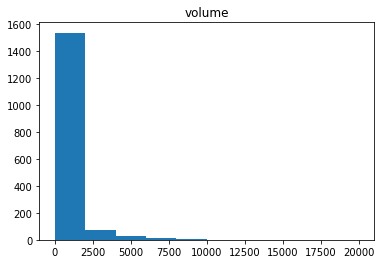

In [139]:
vol_hist = raw_data.hist(column='volume', grid=False)
vol_hist

Even after removing the innacurate volume counts, volume is still heavily skewed to the right with 

Where are the intersections with the highest volume located in the City of Los Angeles? We can look at those locations with volumes outside 3 standard deviations of the mean.

In [140]:
import folium

# Create new LA Basemap specifying map center, zoom level, and using Stamen Terrain tiles
highvol_map = folium.Map([34.109279, -118.266087], tiles='Stamen Toner', zoom_start=11)
# Loop through the df, add each highvol point to the map
for index, row in outlier_volume.iterrows():
    folium.Marker([row['LAT'], row['LON']]).add_to(highvol_map)
# Show the map
print("There are " + str(len(outlier_volume.index)) +
      " volume counts outside +/- 3 st.dev from the mean volume.")
highvol_map

There are 33 volume counts outside +/- 3 st.dev from the mean volume.


Most of these locations fall within two categories:  
* Directly adjacent to a university: 4 counts are near UCLA, and 1 count is near USC
* In a high-dense area: several counts are in Downtown, Hollywood, and Koreatown, some of the densest areas in the City of Los Angeles  

This suggests that density, measured in dataset by `EMPTOT` and `SUM_POPTTL`, and proximity to a school, measured in the dataset by `SCH_CT`, may be important features in predicting pedestrian volumes. This also suggests that these high counts, despite being outliers in the dataset, should not be discarded since they can be explained by the built environment surrounding them.

##### Features

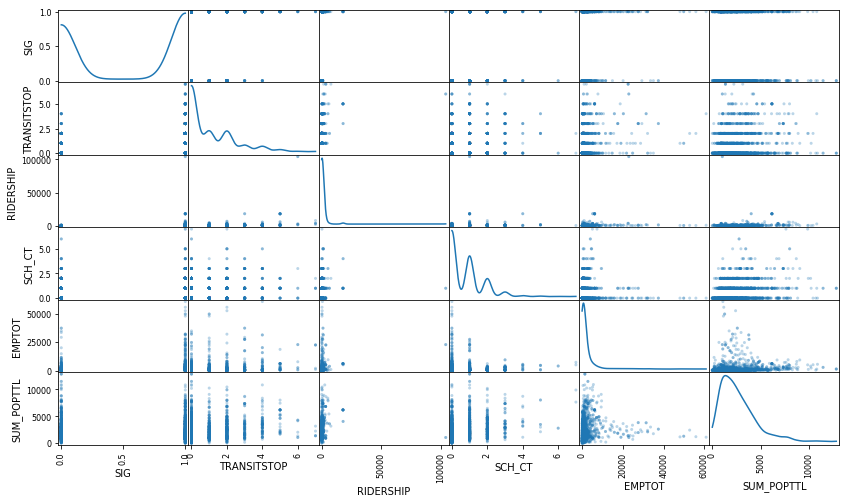

In [81]:
# From customer segments section
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(raw_data.drop(['volume','LAT','LON'], axis=1),
                           alpha = 0.3, figsize = (14,8), diagonal = 'kde');

The above scatterplot matrix shows the relationship between each of the feature pairs in the dataset. 

### Algorithms and Techniques
My proposed solution is to build a regression model that can take inputs from the built environment and predict the daily volume of pedestrians at an intersection. I will test the fit for both a linear model and log linear model, since both have been demonstrated to perform well for different cities. For my project, I prefer implementing a linear or log linear regression model because it is important to be able to describe the effect of each explanatory variable on the output. It is not just important to be able to accurately predict the pedestrian volume; it is also important to understand how the characteristics of the built environment affect the volume. I anticipate my resulting model to take one of two forms shown below:

$Y_i=\beta_0+\beta_1X_{1i}+\beta_2X_{2i}+...\beta_jX_{ji}$  
$Y_i=exp(\beta_0+\beta_1X_{1i}+\beta_2X_{2i}+...\beta_jX_{ji})$  

where:

$Yi$ = weekday pedestrian volume at intersection  
$X_{ji}$ = value of explanatory variable $j$ at intersection $i$  
$\beta_j$ = model coefficient for variable j

### Benchmark
There have been a few attempts to build models estimating the effect of the built environment on pedestrian traffic volume, but none of them have focused on Los Angeles. In addition, most have also used a sample set smaller than my own. Below is a table with the results from a previous model for San Francisco (1):  

Model Structure | Adjusted R^2 Value | F-Value (Test Value) 
--- | --- | ---
Log-Linear| 0.804 | 34.4 (p < .001)



## IV. Methodology

### Data Preprocessing

One of the things I noticed during the data exploration was that there were several `NA` values for the `RIDERSHIP` feature. A `NA` value for this variable meant that there were no transit stops within 100ft of the intersection. For the purposes of this study, I can interpret this as a `RIDERSHIP` value of 0, so I can fill all the `NA` values with 0s for the analysis.

In [103]:
raw_data['RIDERSHIP'].fillna(0, inplace=True)

##### Transforming Skewed Continuous Variables
As also noted in the data exploration, the target variable `volume` and the features `RIDERSHIP`, `EMPTOT`, `SUM_POPTTL` are not normally distributed, all having heavy right skewed distributions. In order to prevent the very large values from negatively affecting the performance of the algorithm, I scaled them using the natural logarithm. Since these variables all have values equal to 0 (and since the logarithm of 0 is undefined), I translated the values by a small amount above 0 to apply the logarithm successfully. 

In [108]:
# Log-transform the skewed features
skewed = ['volume', 'RIDERSHIP', 'EMPTOT', 'SUM_POPTTL']
raw_data[skewed] = raw_data[skewed].apply(lambda x: np.log(x + 1))

raw_data = raw_data[(raw_data.volume > 0)]

volume_raw = raw_data['volume']
features_raw = raw_data.drop('volume', axis=1)

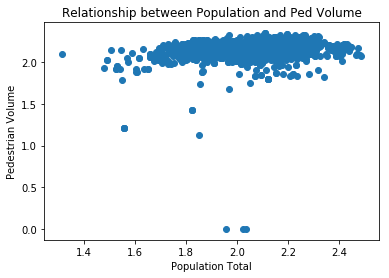

0


In [116]:
plt.scatter(raw_data.EMPTOT, raw_data.SUM_POPTTL)
plt.xlabel("Population Total")
plt.ylabel("Pedestrian Volume")
plt.title("Relationship between Population and Ped Volume")
plt.show()
print(len(raw_data[(raw_data.volume == 0)]))

### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

In [121]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_raw, volume_raw, test_size = 0.30, random_state = 0)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1060 samples.
Testing set has 455 samples.


In [122]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_

## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_

In [123]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [124]:
from sklearn.metrics import r2_score

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
#print("Mean squared error: %.2f"
#      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('R^2 value: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [-0.17179316  0.24563327  0.11218207  0.00876624  0.05265514  0.02083117
  0.47299256  0.34481524]
Variance score: 0.40


ValueError: x and y must be the same size

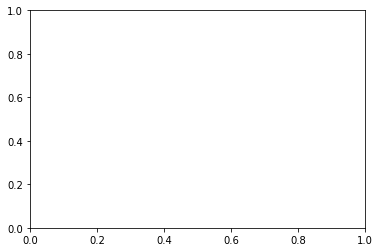

In [84]:
# Plot outputs
plt.scatter(features_test, volume_test,  color='black')
plt.plot(features_test, volume_pred, color='blue', linewidth=3)

In [ ]:
# For each contributing variable, calculate the 95% confidence intervals for the effect each has
# on the predicted variable. Interpret as follows: for each Z increase in X, there will be a V increase
# in Y.

### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_

## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

In [146]:
### Map all the ped data
import math

# Create new LA Basemap specifying map center, zoom level, and using Stamen Toner Tiles
pedvol_map = folium.Map([34.109279, -118.266087],
                        tiles='Stamen Toner',
                        zoom_start=11)



# Map out locations and document labels
locationlist = raw_data[['LAT','LON']].values.tolist()
size = raw_data['volume'].values.tolist()

#for point in range(len(locationlist)):
for point in range(1300):
    folium.CircleMarker(locationlist[point], radius=(math.sqrt(size[point])/5),
                        line_color='#3186cc', fill_color='#3186cc',
                        fill=True).add_to(pedvol_map)

# Show the map
pedvol_map

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

The most challenging aspect of the project was the preprocessing of the data. I spent a considerable amount of time familiarizing myself with the OpenCV library so that I could employ it on this task. Before implementing the OpenCV / OCR solution to process the data, I originally tried to read the data using PDF text extraction tools; however, the performance using those tools was quite poor, and I didn't feel that it would be relaible enough for this project. 

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_

In this case, I think I could build a more robust model with more data. The OpenCV / OCR solution was limited to the ~1.6K sheets I could process using this method; however, there were roughly 5k sheets (in a similar but different PDF format) that I was unable to process. If I was able to get all those sheets transcribed, this would increase the amount of training data by 4x.  Beyond what I will be able to get from these historical counts, the field of machine learning has advanced to the point where we can now install cameras and get much larger datasets on ped volume counts. The City of Los Angeles has not yet implemented this strategy for collecting pedestrian counts; however, it is only a matter of time before that becomes standard in many cities. When this does happen, we will have much more 

In addition to having more volume data, I am sure that I could also build a better model using more data from the built environment. I was able to assemble the data that the literature has shown to be the most important in terms of predicting pedestrian volume; however, I was not able to get the range of data that other researchers have examined. It is also possible that there is some aspect of the built environment that is important but has not yet been revealed in the research. 

## VI. References
1. Schneider, R. J., T. Henry, M. F. Mitman, L. Stonehill, and J. Koehler. Development and Application of a Pedestrian Volume Model in San Francisco. Transportation Research Record: Journal of the Transportation Research Board, No. 2299, 2012, pp. 65–78.
2. Liu, X., and J. Griswold. Pedestrian Volume Modeling: A Case Study of San Francisco. Association of Pacific Coast Geographers Yearbook, Vol. 71, 2009.
3. Pulugurtha, S. S., and S. R. Repaka. Assessment of Models to Measure Pedestrian Activity at Signalized Intersections. In Transportation Research Record: Journal of the Transportation Research Board, No. 2073, Transportation Research Board of the National Academies, Washington, D.C., 2008, pp. 39-48.
4. Schneider, R. J., L. S. Arnold, and D. R. Ragland. Pilot Model for Estimating Pedestrian Intersection Crossing Volumes. In Transportation Research Record: Journal of the Transportation Research Board, No. 2140, Transportation Research Board of the National Academies, Washington, D.C., 2009, pp. 13-26.
5. Jones, M. G., S. Ryan, J. Donlan, L. Ledbetter, L. Arnold, and D. Ragland. Seamless Travel: Measuring Bicycle and Pedestrian Activity in San Diego County and Its Relationship to Land Use, Transportation, Safety, and Facility Type. Alta Planning and Design and Safe Transportation Research and Education Center, University of California, Berkeley, 2010.
6. Haynes, M., and S. Andrzejewski. GIS Based Bicycle & Pedestrian Demand Forecasting Techniques. Presentation to Travel Model Improvement Program, U.S. Department of Transportation. Fehr & Peers Transportation Consultants, San Francisco, Calif., 2010.
7. Miranda-Moreno, L. F., and D. Fernandes. Modeling of Pedestrian Activity at Signalized Intersections: Land Use, Urban Form, Weather, and Spatiotemporal Patterns. In Transportation Research Record: Journal of the Transportation Research Board, No. 2264, Transportation Research Board of the National Academies, Washington, D.C., 2011, pp. 74-82.